In [1]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [2]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/SkinCancer/Dataset.zip" > /dev/null

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Dataset/Test")
data_dir_test = pathlib.Path("/content/Dataset/Train")

In [5]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118
2239


Found 118 files belonging to 9 classes.


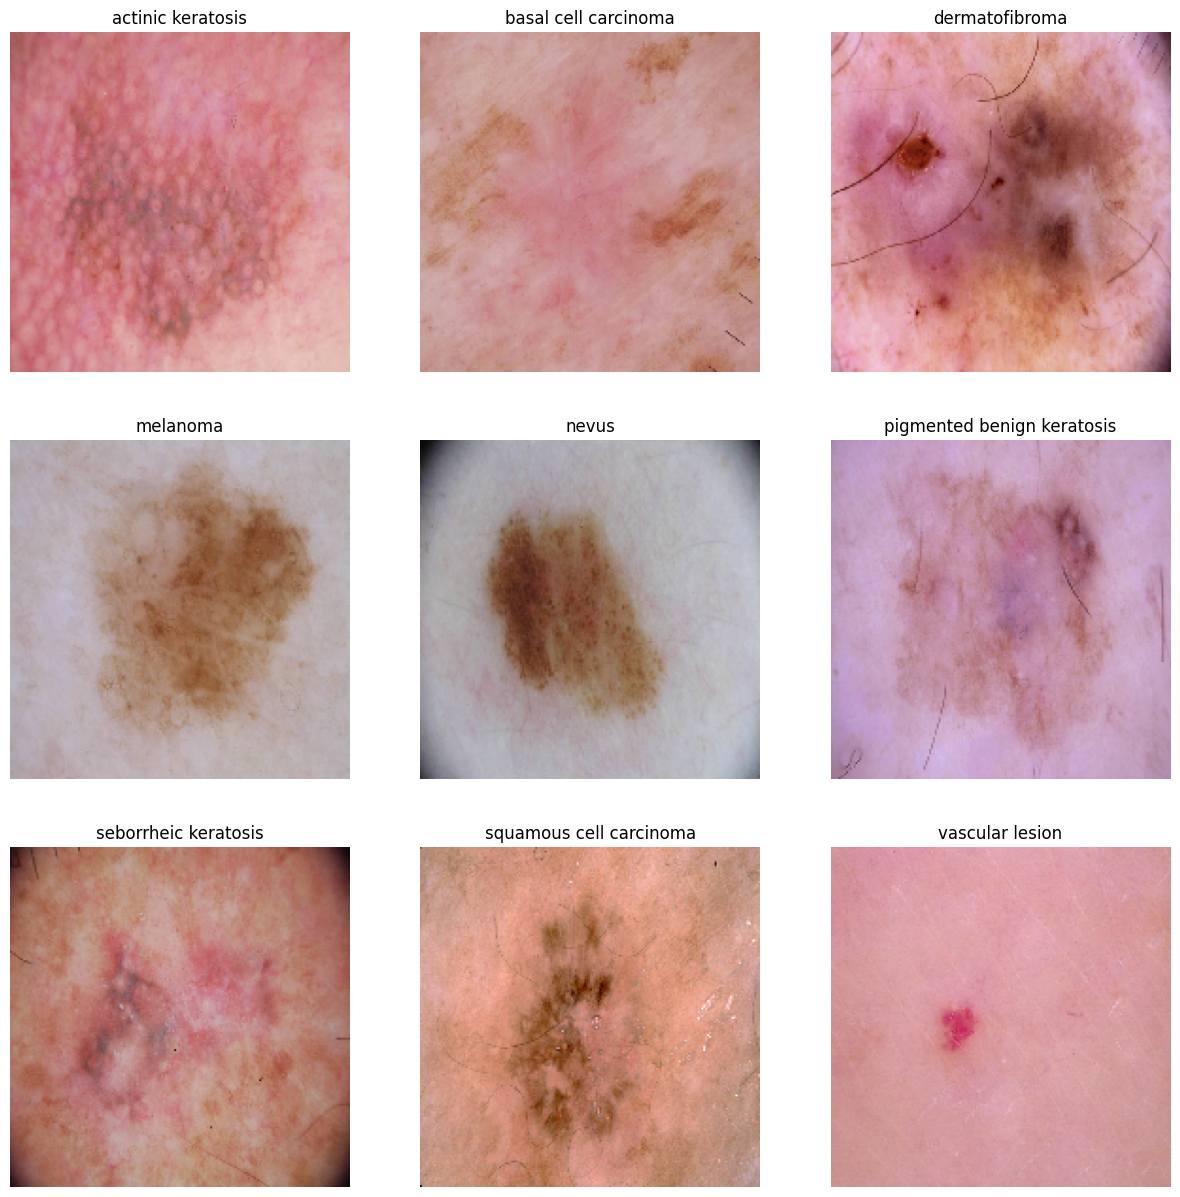

In [6]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [7]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,16
1,vascular lesion,3
2,seborrheic keratosis,3
3,basal cell carcinoma,16
4,dermatofibroma,16
5,melanoma,16
6,nevus,16
7,squamous cell carcinoma,16
8,actinic keratosis,16


<Axes: xlabel='No. of Image', ylabel='Class'>

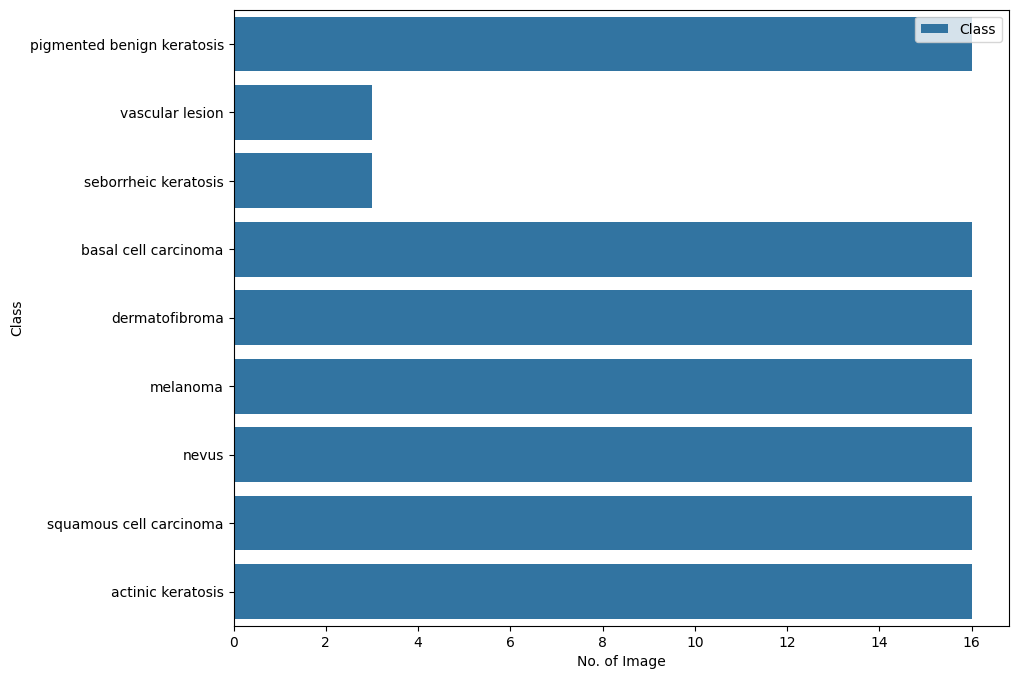

In [8]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [9]:
#install Augmentor
!pip install Augmentor

In [10]:
path_to_training_dataset="/content/Dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A1881CF8A00>: 100%|██████████| 500/500 [00:18<00:00, 27.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A1880043AF0>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A187A7C9270>: 100%|██████████| 500/500 [00:15<00:00, 33.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A18787097E0>: 100%|██████████| 500/500 [01:18<00:00,  6.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7A1880043AF0>: 100%|██████████| 500/500 [01:17<00:00,  6.41 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A17F749EBC0>: 100%|██████████| 500/500 [00:16<00:00, 30.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A17F70DC8E0>: 100%|██████████| 500/500 [00:33<00:00, 14.79 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A17F73731C0>: 100%|██████████| 500/500 [00:14<00:00, 33.75 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A17F749CCA0>: 100%|██████████| 500/500 [00:15<00:00, 32.34 Samples/s]


In [14]:
# Count the total number of images in the training dataset after augmentation
augmented_image_count = len(list(pathlib.Path(path_to_training_dataset).glob('*/*.jpg')))
print(f"Total number of images after augmentation: {augmented_image_count}")

Total number of images after augmentation: 2239


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
path_to_training_dataset = "/content/Dataset/Train/"

# Enable GPU for TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for data augmentation.")
else:
    print("GPU not detected. Ensure CUDA and drivers are installed.")

# Load and augment data for each class
datagen = ImageDataGenerator(
    rotation_range=10,  # Rotation in degrees
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill missing pixels after rotation
)

# Create augmented datasets for each class
for class_name in class_names:
    class_path = f"{path_to_training_dataset}/{class_name}"
    # Use a generator to augment images and save them
    generator = datagen.flow_from_directory(
        directory=path_to_training_dataset,
        classes=[class_name],
        target_size=(128, 128),  # Resize images to desired size
        batch_size=32,
        save_to_dir=class_path,  # Save augmented images to the same class folder
        save_format="jpeg"
    )

    # Generate 500 augmented samples per class
    for _ in range(500 // 32 + 1):  # Adjust to match your batch size
        next(generator)


GPU is available for data augmentation.
Found 614 images belonging to 1 classes.
Found 876 images belonging to 1 classes.
Found 595 images belonging to 1 classes.
Found 938 images belonging to 1 classes.
Found 857 images belonging to 1 classes.
Found 962 images belonging to 1 classes.
Found 577 images belonging to 1 classes.
Found 681 images belonging to 1 classes.
Found 639 images belonging to 1 classes.


In [15]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 118 files belonging to 9 classes.
Using 95 files for training.


In [16]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [17]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer - Changed to use tf.keras.layers.experimental.preprocessing
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

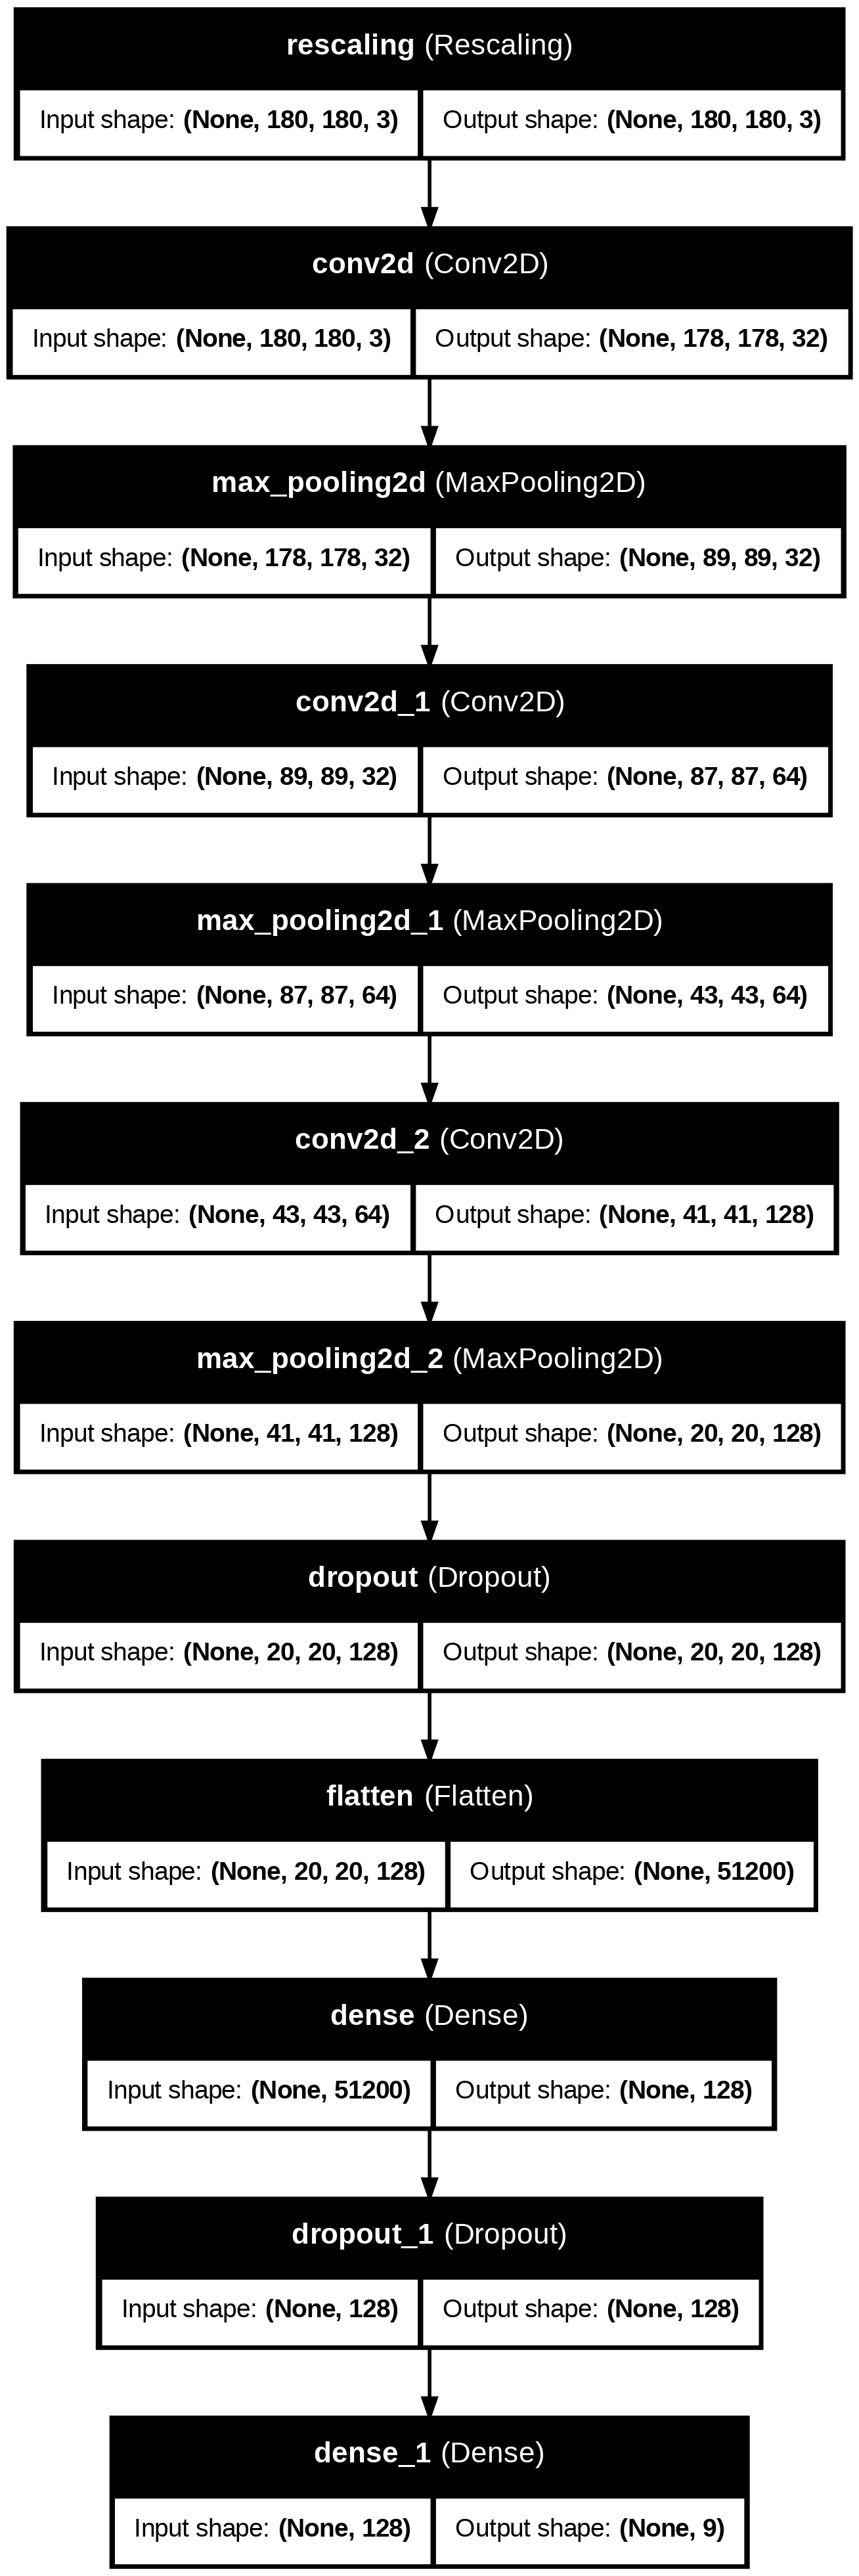

In [21]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for training.")
else:
    print("No GPU detected. Please check your runtime settings.")

# Compile the model
# Adam optimization: A stochastic gradient descent method based on adaptive estimation of first-order and second-order moments.
# categorical_crossentropy: A loss function for multi-class classification with two or more output labels.
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# ModelCheckpoint callback: Save model or weights (in a checkpoint file) at intervals to continue training from the saved state.
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping callback: Stop training when the monitored metric stops improving.
earlystop = EarlyStopping(monitor="val_accuracy", patience=15, mode="auto", verbose=1)

# Example of fitting the model (use your own data and parameters)
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint, earlystop])


GPU is available for training.


In [28]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2594 - loss: 1.9269
Epoch 1: val_accuracy improved from -inf to 0.04348, saving model to model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2034 - loss: 2.1171 - val_accuracy: 0.0435 - val_loss: 2.4289
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2085 - loss: 1.9413
Epoch 2: val_accuracy improved from 0.04348 to 0.13043, saving model to model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.2169 - loss: 1.9405 - val_accuracy: 0.1304 - val_loss: 2.3597
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1608 - loss: 2.0142
Epoch 3: val_accuracy improved from 0.13043 to 0.17391, saving model to model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.1732 - loss: 2.0017 - val_accuracy: 0.1739 - val_loss: 2.1930
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2485 - loss: 1.8965
Epoch 4: val_accuracy did not improve from 0.17391
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

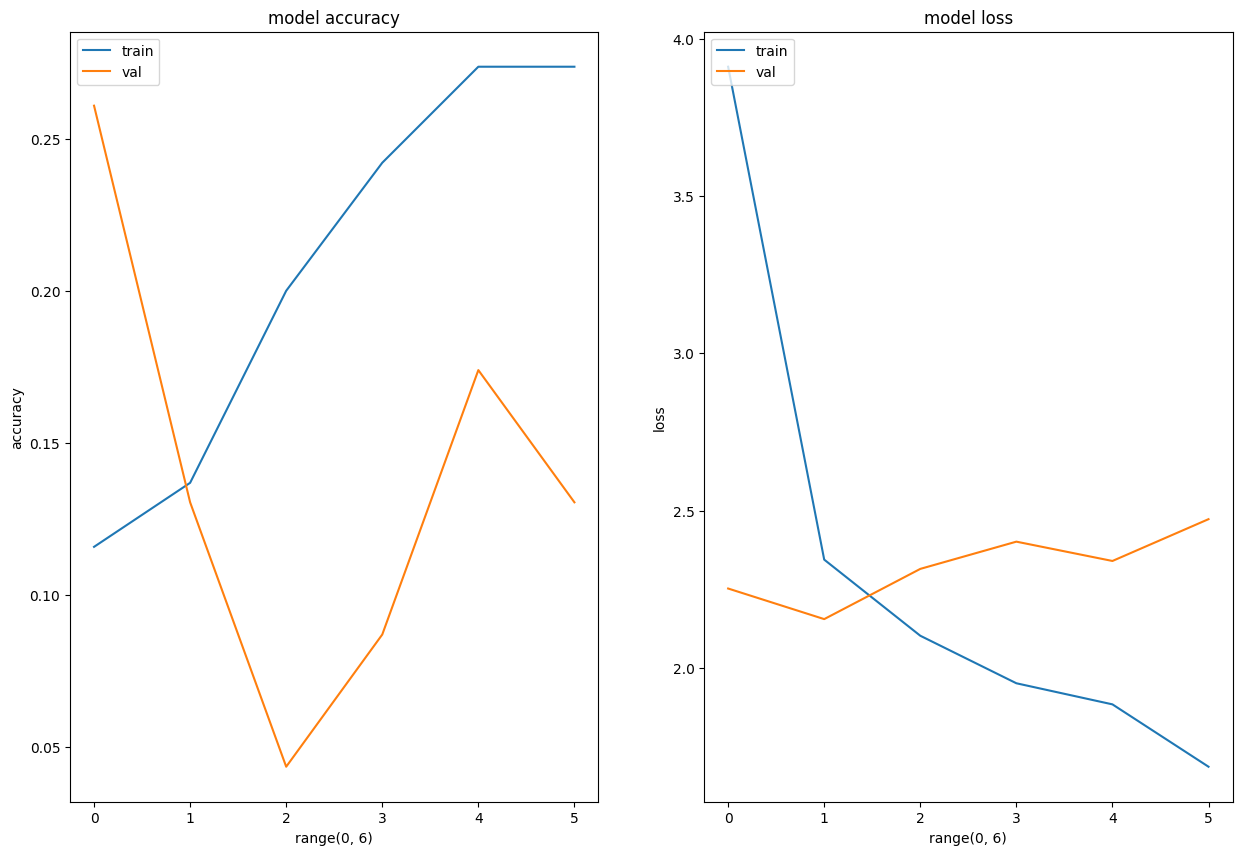

In [25]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
Actual Class basal cell carcinoma
Predictive Class nevus


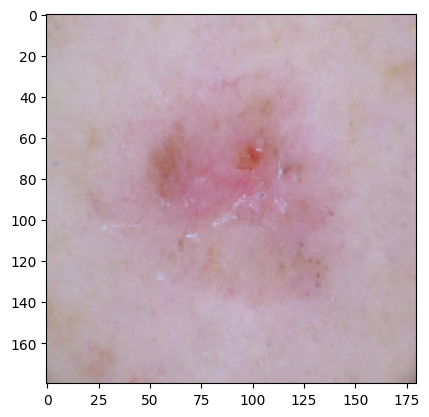

In [26]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )